In [3]:

#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [5]:
# note, you'll need to import the DF from this kaggle notebook, I just downloaded it
# https://www.kaggle.com/datasets/uciml/adult-census-income
df = pd.read_csv('adult.csv')

# Split the data into training and testing sets
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)


In [6]:
train_df.head()

,age,workclass,fnlwgt,education,...,capital.loss,hours.per.week,native.country,income
14160,29,Private,280618,Some-college,...,0,40,United-States,<=50K
27048,19,Private,439779,Some-college,...,0,15,United-States,<=50K
28868,28,Private,204734,Some-college,...,0,40,United-States,<=50K
5667,35,Private,107991,11th,...,0,45,United-States,<=50K
7827,20,Private,54152,Some-college,...,0,30,?,<=50K


In [7]:
train_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [13]:
dep_var = 'income'

In [18]:
df['fnlwgt'].unique()

array([ 77053, 132870, 186061, ...,  34066,  84661, 257302])

In [19]:
df.size

488415

In [20]:
# prompt: here's another person preparing splits, prepare htem for me just splitting the dataset 70 train and 30 test
# cond = (df.saleYear<2011) | (df.saleMonth<10)
# train_idx = np.where( cond)[0]
# valid_idx = np.where(~cond)[0]
# splits = (list(train_idx),list(valid_idx))

import pandas as pd
import numpy as np

# Assuming your dataframe is named 'df'

# Split the data into training and testing sets (70% train, 30% test)
train_df = df.sample(frac=0.7, random_state=42)  # Use a random state for reproducibility
test_df = df.drop(train_df.index)

# Now you have train_df and test_df ready to use


In [22]:
train_idx = list(my_train_df.index)
valid_idx = list(eval_df.index)
splits = (train_idx, valid_idx)


In [23]:
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)


In [25]:
to.show(3)


,workclass,education,marital.status,occupation,relationship,race,sex,native.country,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income
3288,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,?,50,75472,9,4386,0,40,<=50K
3855,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,24,296045,4,2635,0,38,<=50K
3734,Private,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States,39,49020,13,3103,0,48,>50K


In [27]:
xs,y = to.train.xs,to.train.y


In [28]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


In [49]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [50]:
# model and feature importance
# 18000 samples, use 2000
m = rf(xs, y, max_samples=5000);
fi = rf_feat_importance(m, xs)


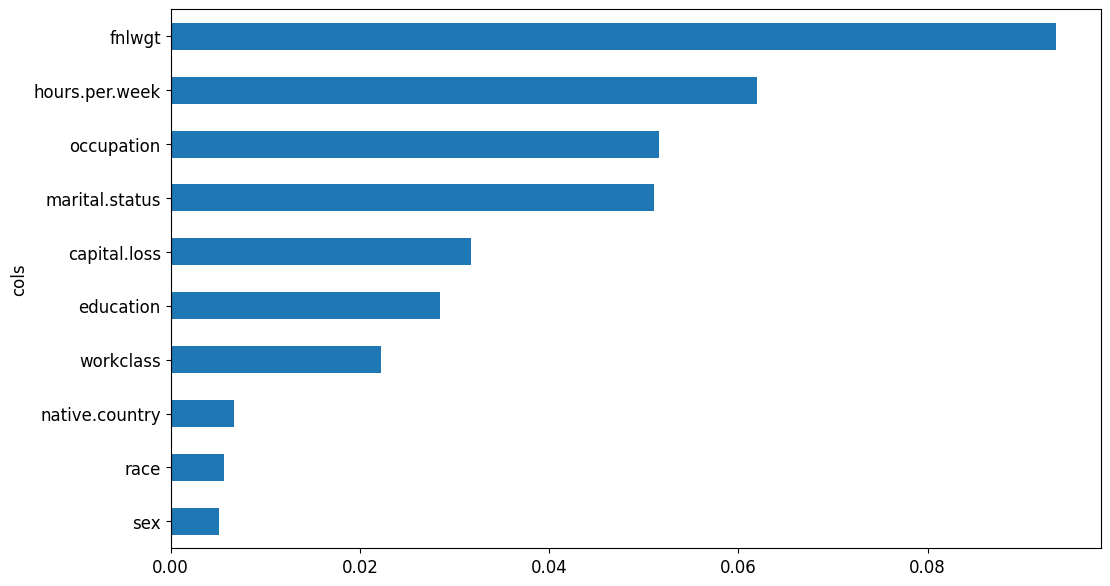

In [51]:
# plotthe most important features
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:10]);

In [43]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=10000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_


In [53]:
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]

get_oob(xs_imp,)
# oof, terrible error

0.4654133662103208

In [58]:
!pip install treeinterpreter
!pip install waterfallcharts
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

/usr/local/lib/python3.10/dist-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/usr/local/lib/python3.10/dist-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


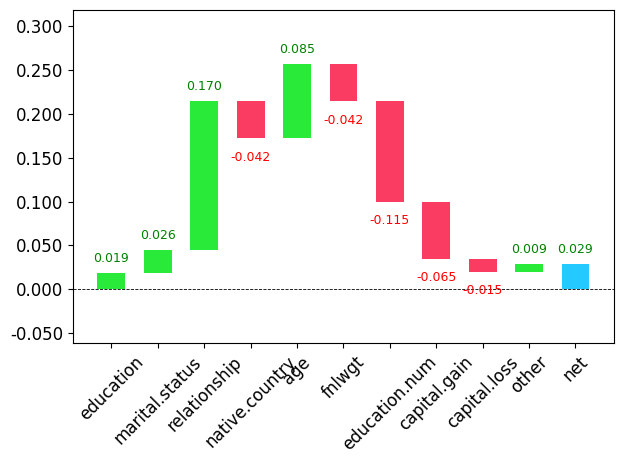

In [61]:
row = xs.iloc[:5]

prediction,bias,contributions = treeinterpreter.predict(m, row.values)

waterfall(xs.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');